In [1]:
import pandas as pd
import tensorflow as tf

In [ ]:
tf.random.set_seed(42)

In [83]:
df = pd.read_csv('new_poems_unstemmed.csv')

In [84]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [85]:
df['content'] = df['content'].fillna('')

In [140]:
len(df['content'])

5281

In [86]:
tokenizer = Tokenizer(num_words=10000)

In [87]:
def reduceLength(x):
  words = x.split()
  first_words = ' '.join(words[:900])
  return first_words

In [88]:
df['content'] = df['content'].apply(lambda x : reduceLength(x))

In [89]:
len(df['content'][3000])

1121

In [90]:
tokenizer.fit_on_texts(list(df['content'].values))

In [91]:
sequences = tokenizer.texts_to_sequences(df['content'].values)

In [92]:
max_len = max(len(x) for x in sequences)

In [93]:
max_len

899

In [94]:
padded_sequences = pad_sequences(sequences, max_len, padding="post", truncating="post")

In [95]:
x_train = padded_sequences
y_train = df['type_num'].values

In [96]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [130]:
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.4):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)

        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = layers.Dropout(rate)

        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout3 = layers.Dropout(rate)

        self.layernorm4 = layers.LayerNormalization(epsilon=1e-6)  
        self.dropout4 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)

        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        out2 = self.layernorm2(out1 + ffn_output)

        ffn_output2 = self.ffn(out2)
        ffn_output2 = self.dropout3(ffn_output2, training=training)

        out3 = self.layernorm3(out2 + ffn_output2)

        ffn_output3 = self.ffn(out3)
        ffn_output3 = self.dropout3(ffn_output3, training=training)

        return self.layernorm4(out3 + ffn_output3)

In [131]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [132]:
vocab_size = 10000
maxlen = max_len

In [133]:
max_len

899

In [141]:
embed_dim = 32
num_heads = 6
ff_dim = 64
num_blocks = 12

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_blocks)]
for transformer_block in transformer_blocks:
    x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(60, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(45, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(54, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [136]:
#model.summary()

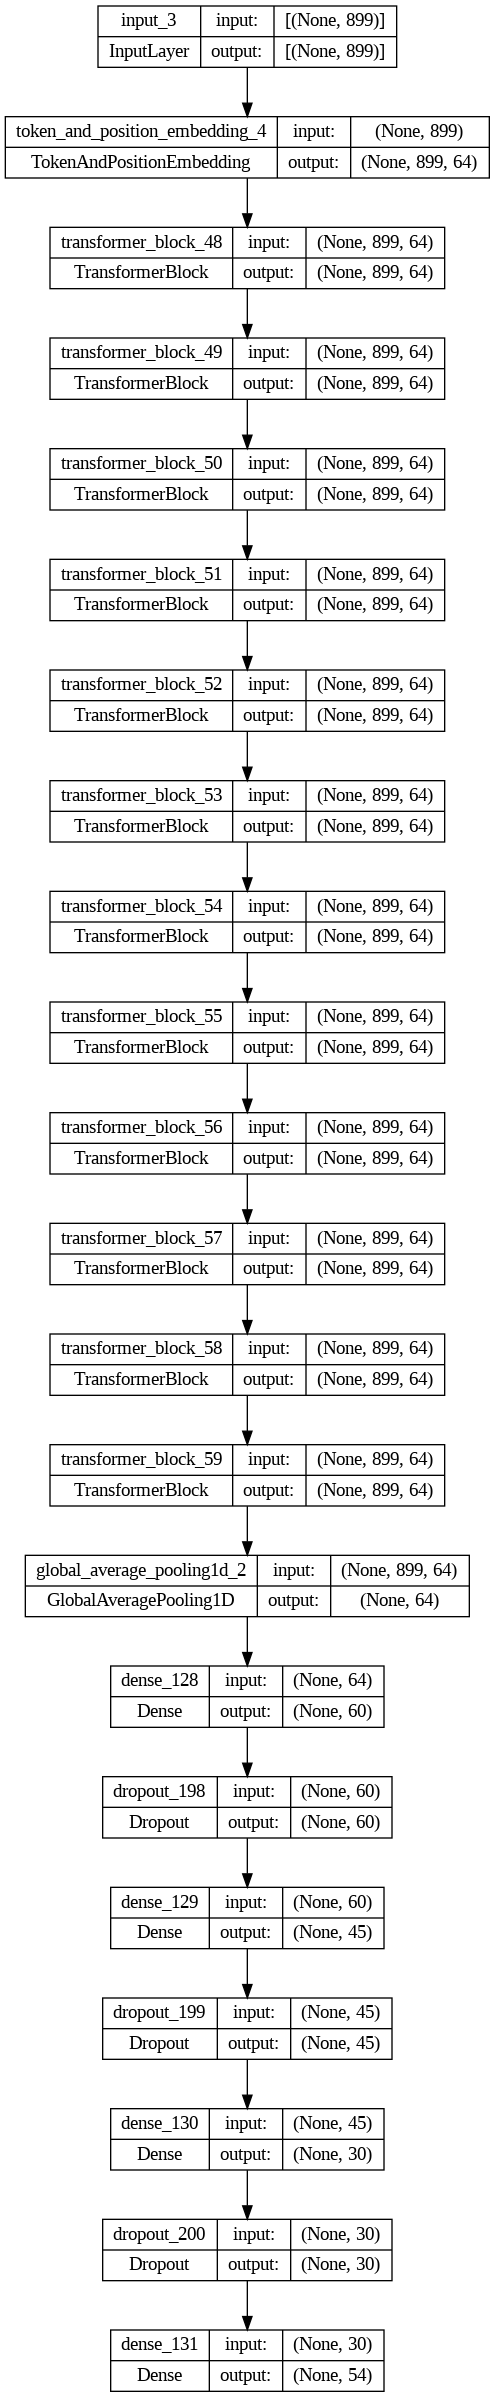

In [137]:
tf.keras.utils.plot_model(model, show_shapes=True,)

In [138]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=8000, decay_rate=0.9)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [139]:
history = model.fit(
    x_train, y_train, batch_size=48, epochs=6, validation_split=0.1
)

Epoch 1/6
99/99 [==============================] - 174s 1s/step - loss: 4.0368 - accuracy: 0.0204 - val_loss: 4.0380 - val_accuracy: 0.0000e+00
Epoch 2/6
99/99 [==============================] - 148s 2s/step - loss: 4.0170 - accuracy: 0.0200 - val_loss: 4.0387 - val_accuracy: 0.0000e+00
Epoch 3/6
99/99 [==============================] - 148s 1s/step - loss: 4.0026 - accuracy: 0.0213 - val_loss: 4.0402 - val_accuracy: 0.0000e+00
Epoch 4/6
99/99 [==============================] - 148s 1s/step - loss: 4.0015 - accuracy: 0.0204 - val_loss: 4.0693 - val_accuracy: 0.0000e+00
Epoch 5/6
99/99 [==============================] - 144s 1s/step - loss: 3.9911 - accuracy: 0.0194 - val_loss: 4.0772 - val_accuracy: 0.0000e+00
Epoch 6/6
99/99 [==============================] - 148s 1s/step - loss: 3.9911 - accuracy: 0.0234 - val_loss: 4.0708 - val_accuracy: 0.0000e+00


In [26]:
correspondings = []

In [27]:
for i in y_train:
  if i not in correspondings:
    correspondings.append(i)

In [28]:
corresponding_types = []

In [29]:
poems_we_will_use = ['alone', 'anger', 'beauty', 'believe', 'change', 'childhood', 'christmas', 'crazy', 'dark', 'death', 'depression', 'evil', 'faith', 'fear', 'friend', 'funny', 'life', 'love', 'lust', 'money', 'murder', 'romance', 'sleep', 'war', 'winter', 'success', 'travel', 'passion', 'power', 'peace', 'nature', 'lonely', 'girl', 'god', 'future', 'butterfly', 'carpe diem', 'dance', 'destiny', 'dream', 'family', 'food', 'greed', 'happy', 'hate', 'laughter', 'kiss', 'night', 'sky', 'star', 'summer', 'time', 'truth', 'wdding']

In [30]:
for i in correspondings:
  corresponding_types.append(poems_we_will_use[int(i)])

In [ ]:
corresponding_types

In [34]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
import re

In [36]:
stemmer = PorterStemmer()

In [37]:
def clean_sentences(sentence):
    #text = sentence[0:500]
    words = sentence.split()
    first_200_words = ' '.join(words[:900])
    text = first_200_words.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.split()
    #words = [word for word in words if word not in stopwords.words('english')]
    cleaned_sentence = " ".join(words)
    return cleaned_sentence

In [38]:
text_ = '''Beneath the shroud of shadows deep,
A soul in torment, secrets to keep.
Whispers of despair in the silent air,
A melancholy song, a heart laid bare.

In the hollow echoes of the night,
A desolate spirit, devoid of light.
Tangled thoughts, a web of dread,
A journey through the shadows, the soul has fled.

A leaden sky, devoid of stars,
A broken vessel sailing through scars.
Tears like rain in the silent storm,
A symphony of sorrow, a heart forlorn.

The moon weeps in a veiled lament,
A world obscured, a heart fragment.
Echoes of laughter, distant and cold,
In the labyrinth of despair, the spirit's hold.

Darkened petals, wilted bloom,
A soul entwined in relentless gloom.
Silent screams within the mind,
A shattered sanctuary, love declined.

Oh, tortured heart in shadows draped,
In the caverns of sorrow, dreams escaped.
A dance with shadows, a funeral pyre,
In the haunting silence, a soul's requiem entire. '''

In [39]:
text = '''
In twilight's tender, soft embrace we find,
A love that blooms, an eternal bind.
Beneath the moonlit sky so deep,
Our hearts entwined, sweet promises to keep.

Your gaze, a melody, a gentle song,
In your presence, where I truly belong.
Eyes that sparkle like stars above,
Igniting passion, an endless love.

Your touch, a whisper on the summer breeze,
A dance of fingertips, a sweet tease.
In every moment, our spirits unite,
A symphony of love, pure and bright.

Through fields of flowers, our journey we trace,
Hand in hand, a tender embrace.
Each step, a promise, each moment, divine,
Our souls intertwined, forever entwined.

As seasons change, and time moves on,
Our love, like a river, ever strong.
In the tapestry of life, our story's spun,
A love poem written, two hearts as one.
'''

In [40]:
poem = '''
In moonlit whispers, shadows dance,
A tapestry of night's romance.
Stars, like diamonds, adorn the sky,
A cosmic waltz, where dreams comply.

Soft breezes carry tales untold,
Through ancient trees and valleys old.
Whispers of a secret lore,
Where mystic realms forever soar.

In gardens bathed in silver light,
Flowers bloom, a spell so bright.
Petals sigh in the zephyr's kiss,
Nature's sonnet, pure and bliss.

On the canvas of the vast unknown,
Celestial art, a masterpiece sown.
Galaxies weave tales of yore,
In the cosmic sea, we explore.

Ephemeral moments, fleeting grace,
Time's embrace, a gentle chase.
Heartbeats echo in the night,
A symphony of love takes flight.

Oh, moonlit poet, pen in hand,
Craft verses upon the starry strand.
Capture the essence of the sublime,
In the verses of this fleeting time.

'''

In [41]:
angry_poem = '''
Anger is a form of fear
Anger is what I’m waiting to hear
Anger is deep down inside me
Anger drives me crazy
Anger is what turns me on
Anger is what turns me off
Anger is my enemy
Anger is my pal
Anger is gonna kill me
Anger is gonna save me
Anger might just help me
Find my true love.............
..........................Ma ybe?
'''

In [107]:
cleaned_text = clean_sentences(text_)

In [108]:
cleaned_text

'beneath the shroud of shadows deep a soul in torment secrets to keep whispers of despair in the silent air a melancholy song a heart laid bare in the hollow echoes of the night a desolate spirit devoid of light tangled thoughts a web of dread a journey through the shadows the soul has fled a leaden sky devoid of stars a broken vessel sailing through scars tears like rain in the silent storm a symphony of sorrow a heart forlorn the moon weeps in a veiled lament a world obscured a heart fragment echoes of laughter distant and cold in the labyrinth of despair the spirit s hold darkened petals wilted bloom a soul entwined in relentless gloom silent screams within the mind a shattered sanctuary love declined oh tortured heart in shadows draped in the caverns of sorrow dreams escaped a dance with shadows a funeral pyre in the haunting silence a soul s requiem entire'

In [109]:
tokens = tokenizer.texts_to_sequences([cleaned_text])

In [110]:
padded_tokens = pad_sequences(tokens, max_len, padding="post", truncating="post")

In [ ]:
padded_tokens

In [126]:
predictions = model.predict(padded_tokens)

1/1 [==============================] - 0s 78ms/step


In [127]:
predictions[0]

array([0.01737187, 0.01896599, 0.01971479, 0.01855864, 0.01505393,
       0.01927665, 0.01959588, 0.01801522, 0.01943951, 0.0202282 ,
       0.01658261, 0.01874224, 0.01674997, 0.0203757 , 0.02261494,
       0.01962295, 0.01667242, 0.02207046, 0.01948074, 0.0187368 ,
       0.01616787, 0.01892564, 0.02022331, 0.01729514, 0.01835124,
       0.01829016, 0.0180546 , 0.02077968, 0.01725322, 0.01767139,
       0.01732874, 0.01539698, 0.0212419 , 0.02164401, 0.01794685,
       0.01800746, 0.01665343, 0.01884054, 0.01647376, 0.02312372,
       0.0171878 , 0.01792702, 0.01969313, 0.01735835, 0.01977008,
       0.01717962, 0.01813556, 0.01723521, 0.01828064, 0.01813987,
       0.02048216, 0.01728193, 0.01754623, 0.01624332], dtype=float32)

In [128]:
genre_probabilities = dict(zip(corresponding_types, predictions[0]))
sum = 0
# Displaying the probability percentages for each genre
for genre, probability in genre_probabilities.items():
    print(f"{genre}: {probability * 100:.2f}%")
    sum += probability * 100
print(sum)

alone: 1.74%
anger: 1.90%
beauty: 1.97%
believe: 1.86%
butterfly: 1.51%
carpe diem: 1.93%
change: 1.96%
childhood: 1.80%
christmas: 1.94%
crazy: 2.02%
dance: 1.66%
dark: 1.87%
death: 1.67%
depression: 2.04%
destiny: 2.26%
dream: 1.96%
evil: 1.67%
faith: 2.21%
family: 1.95%
fear: 1.87%
food: 1.62%
friend: 1.89%
funny: 2.02%
future: 1.73%
girl: 1.84%
god: 1.83%
greed: 1.81%
happy: 2.08%
hate: 1.73%
kiss: 1.77%
laughter: 1.73%
life: 1.54%
lonely: 2.12%
love: 2.16%
lust: 1.79%
money: 1.80%
murder: 1.67%
nature: 1.88%
night: 1.65%
passion: 2.31%
peace: 1.72%
power: 1.79%
romance: 1.97%
sky: 1.74%
sleep: 1.98%
star: 1.72%
success: 1.81%
summer: 1.72%
time: 1.83%
travel: 1.81%
truth: 2.05%
war: 1.73%
winter: 1.75%
98.37567219510674
